In [15]:
# encoding: utf-8
# Author: Zhuangwei Kang
%matplotlib inline
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

In [16]:
def parse_output(output, fields):
    data = {}
    for fld in fields:
        val = output.split(fld)[1].strip('\n').strip()
        avoid = [' ', '', '\n', 'us', '%']
        for x in avoid:
            val = val.replace(x, '')

        key = fld.lower().replace(' ', '')
        if '.' in key:
            key = key.replace('.', '_')
        if ':' in key:
            key = key.replace(':', '')

        try:
            data.update({key: float(val)})
        except ValueError:
            if fld == 'Lost:':
                val = float(val.split('(')[1].split(')')[0])
            data.update({key: val})
        output = output.split(fld)[0]
    return data


def parse_latency(perftest_output):
    fields = ['CPU:', '99.9999%', '99.99%', '99%', '90%', '50%', 'Max', 'Min', 'Std', 'Latency: Ave', 'Length:']
    latency_perf = parse_output(perftest_output, fields)
    return latency_perf


def parse_throughput(perftest_output):
    fields = ['CPU:', 'Lost:', 'Mbps(ave):', 'Packets/s(ave):', 'Packets:', 'Length:']
    throughput_perf = parse_output(perftest_output, fields)
    return throughput_perf


def find_line(fname):
    with open(fname) as f:
        for l in f.readlines():
            if 'Length' in l:
                return l


def load_data(tests, plugins):
    throughput_perf = []
    latency_perf = []
    for cni in plugins:
        for t in tests:
            perfs = []
            subs = [sub for sub in os.listdir('logs/%s/test-%d/' % (cni, t)) if 'sub' in sub]
            for sub in subs:
                perftest_output = find_line('logs/%s/test-%d/%s' % (cni, t, sub))
                tperf = parse_throughput(perftest_output)
                perfs.append(tperf)
            avg_perf = {}
            for fld in perfs[0]:
                avg_perf.update({fld: 0})
            for fld in perfs[0]:
                for perf in perfs:
                    avg_perf[fld] += perf[fld]
            for fld in avg_perf:
                avg_perf[fld] /= len(subs)
            avg_perf.update({'test': t, 'cni': cni})
            throughput_perf.append(avg_perf)

            perftest_output = find_line('logs/%s/test-%d/rtiperftest-pub0.log' % (cni, t))
            lperf = parse_latency(perftest_output)
            lperf.update({'test': t, 'cni': cni})
            latency_perf.append(lperf)
    return pd.DataFrame(throughput_perf), pd.DataFrame(latency_perf)      


In [17]:
plugins = ['flannel-hostgw', 'flannel-vxlan', 'kube-router', 'weavenet']

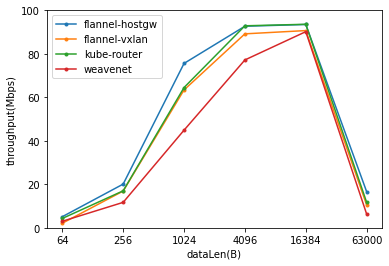

In [18]:
# dataLen test
data_len_test = range(6)
throughput_perf, latency_perf = load_data(data_len_test, plugins)

data_len = [64, 256, 1024, 4096, 16384, 63000]
x = np.arange(6)
total_width, n = 0.8, len(plugins)
width = total_width / n
# x = x - (total_width - width) / 2

plt.xticks(range(len(data_len)), data_len, rotation=0)
plt.ylim(0, 100)
for i, cni in enumerate(plugins):
    thr = throughput_perf[throughput_perf['cni'] == cni]['mbps(ave)']
    plt.plot(x, thr, label=cni, marker='.')
plt.legend()
plt.xlabel('dataLen(B)')
plt.ylabel('throughput(Mbps)')
plt.show()

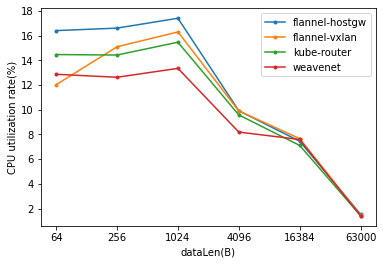

In [19]:
plt.xticks(range(len(data_len)), data_len, rotation=0)
for i, cni in enumerate(plugins):
    cpu = throughput_perf[throughput_perf['cni'] == cni]['cpu']
    plt.plot(x, cpu, label=cni, marker='.')
plt.legend()
plt.xlabel('dataLen(B)')
plt.ylabel('CPU utilization rate(%)')
plt.show()

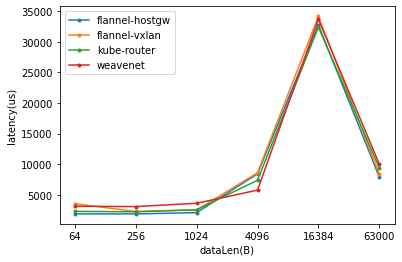

In [20]:
plt.xticks(range(len(data_len)), data_len, rotation=0)
for i, cni in enumerate(plugins):
    lat = latency_perf[latency_perf['cni'] == cni]['latencyave']
    plt.plot(x, lat, label=cni, marker='.')
plt.legend()
plt.xlabel('dataLen(B)')
plt.ylabel('latency(us)')
plt.show()

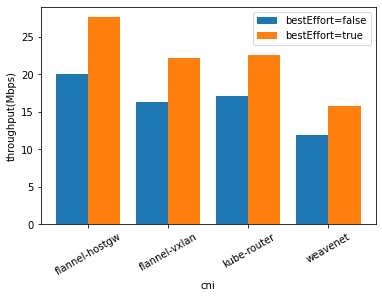

In [21]:
# reliability test
reliable_test = [6,7]
throughput_perf, latency_perf = load_data(reliable_test, plugins)
x = np.arange(len(plugins))
total_width, n = 0.8, 2
width = total_width / n
x = x - (total_width - width) / 2

labels = ['bestEffort=false', 'bestEffort=true']
plt.xticks(range(len(plugins)), plugins, rotation=30)
for i, t in enumerate(reliable_test):
    thr = throughput_perf[throughput_perf['test'] == t]['mbps(ave)']
    plt.bar(x + i*width, thr, label=labels[i], width=width)
plt.legend()
plt.xlabel('cni')
plt.ylabel('throughput(Mbps)')
plt.show()

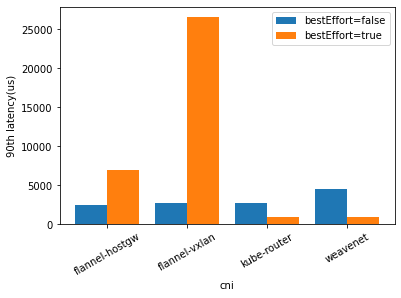

In [22]:
# reliability test
plt.xticks(range(len(plugins)), plugins, rotation=30)
for i, t in enumerate(reliable_test):
    lat = latency_perf[latency_perf['test'] == t]['90%']
    plt.bar(x + i*width, lat, label=labels[i], width=width)
plt.legend()
plt.xlabel('cni')
plt.ylabel('90th latency(us)')
plt.show()

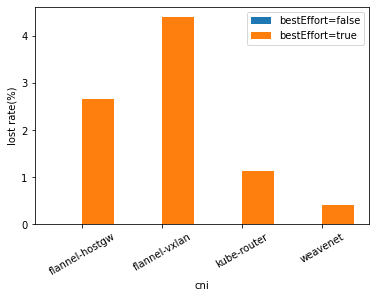

In [23]:
# reliability test
plt.xticks(range(len(plugins)), plugins, rotation=30)
for i, t in enumerate(reliable_test):
    thr = throughput_perf[throughput_perf['test'] == t]['lost']
    plt.bar(x + i*width, thr, label=labels[i], width=width)
plt.legend()
plt.xlabel('cni')
plt.ylabel('lost rate(%)')
plt.show()

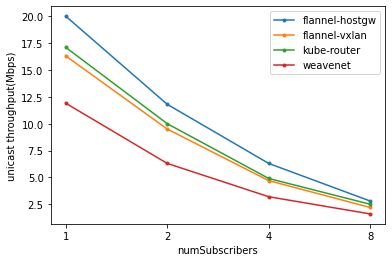

In [24]:
# numSubscriber unicast test
numsub_test = [6, 8, 9, 10]
throughput_perf, latency_perf = load_data(numsub_test, plugins)

num_subs = [1,2,4,8]
x = np.arange(4)
total_width, n = 0.8, len(plugins)
width = total_width / n
# x = x - (total_width - width) / 2

plt.xticks(x, num_subs, rotation=0)
for i, cni in enumerate(plugins):
    thr = throughput_perf[throughput_perf['cni'] == cni]['mbps(ave)']
    plt.plot(x, thr, label=cni, marker='.')
plt.legend()
plt.xlabel('numSubscribers')
plt.ylabel('unicast throughput(Mbps)')
plt.show()

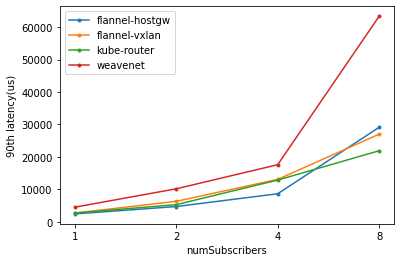

In [25]:
# numSubscriber unicast test
plt.xticks(x, num_subs, rotation=0)
for i, cni in enumerate(plugins):
    lat = latency_perf[latency_perf['cni'] == cni]['90%']
    plt.plot(x, lat, label=cni, marker='.')
plt.legend()
plt.xlabel('numSubscribers')
plt.ylabel('90th latency(us)')
plt.show()

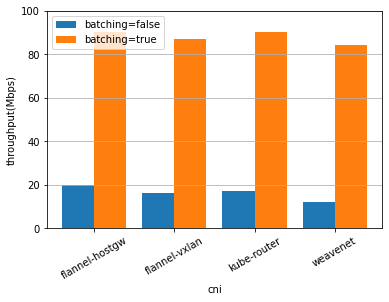

In [26]:
# batching test
batch_test = [6, 11]
throughput_perf, latency_perf = load_data(batch_test, plugins)

x = np.arange(len(plugins))
total_width, n = 0.8, 2
width = total_width / n
x = x - (total_width - width) / 2

labels = ['batching=false', 'batching=true']
plt.xticks(range(len(plugins)), plugins, rotation=30)
plt.ylim(0, 100)
for i, t in enumerate(batch_test):
    thr = throughput_perf[throughput_perf['test'] == t]['mbps(ave)']
    plt.bar(x + i*width, thr, label=labels[i], width=width)
plt.grid(axis='y')
plt.legend()
plt.xlabel('cni')
plt.ylabel('throughput(Mbps)')
plt.show()

In [27]:
multicast_plugins = ['weavenet']

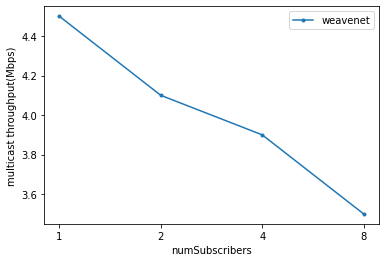

In [28]:
# multicast test
multicast_test = [12,13,14,15]
throughput_perf, latency_perf = load_data(multicast_test,  multicast_plugins)

num_subs = [1,2,4,8]
x = np.arange(4)
total_width, n = 0.8, len(plugins)
width = total_width / n
# x = x - (total_width - width) / 2

plt.xticks(x, num_subs, rotation=0)
for i, cni in enumerate(multicast_plugins):
    thr = throughput_perf[throughput_perf['cni'] == cni]['mbps(ave)']
    plt.plot(x, thr, label=cni, marker='.')
plt.legend()
plt.xlabel('numSubscribers')
plt.ylabel('multicast throughput(Mbps)')
plt.show()